In [43]:
# Quietly compile autovarlamba.f90
import os
import sys
# os.system("f2py -c -m autovarlambda SR.read_write_as.for f2py_autovarlambda.f90 --quiet")
# print("\n===>>> autovarlambda compiled with f2py <<<===")

# Import other stuff
import numpy as np
import autovarlambda
import time
import pandas as pd
import yaml
import GPy
import GPyOpt
from numpy.random import seed
seed(123456)


import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import gridspec

colors=['k','r','g','b','m','y','c','tab:blue',
        'tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray']
orb=['1s','2s','2p','3s','3p','3d','4s','4p','4d','4f','5s','5p','5d','5f','5g']
symbs=['o','s','v','^','>','<','o','o','o','o','o','o','o','o','o']

# Input parameters
global gridtype, cfgs, maxevals, mtype, aftype, afweight, gridtype, igrid, initer, ipol
global nlamvar, maxlam, minlam, mfunc, ifun, minst, imin, nener, wi, igi

print("\n===>>> Input parameters <<<===\n")
with open("varlam_gpyopt.yml", 'r') as stream:
    data_loaded=yaml.load(stream)

cfgs=data_loaded.get("cfgs")
if cfgs is None: raise ValueError("Error: cfgs not defined.")

initer=data_loaded.get("initer")
if initer is None: raise ValueError("Error: initer not defined.")
print(" * initial evaluations: "+str(initer))

maxevals=data_loaded.get("maxevals")
if maxevals is None: raise ValueError("Error: maxevals not defined.")
print(" * evaluations: "+str(maxevals))

mtype=data_loaded.get("mtype")
if mtype=="GP": print(" * model type: "+mtype)
elif mtype is None: 
    mtype="GP"
    print("Warning: model type not defined. Use default: GP")
else: raise ValueError("Error: "+mtype+" not implemented.")

aftype=data_loaded.get("aftype")
if aftype=="EI" or aftype=="MPI" or aftype=="LCB": print(" * acquisition function type: "+aftype)
elif aftype is None: 
    aftype="EI"
    print("Warning: acquisition function type not defined. Use default: EI")
else: raise ValueError("Error: "+mtype+" not implemented.")

afweight=data_loaded.get("afweight")
if afweight: print(" * acquisition function weight: "+str(afweight))
elif afweight is None: 
    afweight=1.
    print("Warning: acquisition function weight not defined. Use default: 1.")

gridtype=data_loaded.get("gridtype")
if gridtype=="continuous":
    igrid=0
    print(" * grid type: "+gridtype)
elif gridtype is None: 
    igrid=0
    print("Warning: grid type not defined. Use default: continuous")
else: raise ValueError("Error: "+gridtype+" not implemented.")

nlamvar=data_loaded.get("nlamvar")
if nlamvar is None: raise ValueError("Error: nlamvar not defined.")

maxlam=data_loaded.get("maxlam")
minlam=data_loaded.get("minlam")
if maxlam is None or minlam is None: raise ValueError("Error: maxlam and/or minlam not defined.")

mfunc=data_loaded.get("mfunc")
if mfunc=="Er":
    ifun=0
    print(" * minimization function: sum of weighted relative errors")
elif mfunc=="Er**2":
    ifun=1
    print(" * minimization function: sum of weighted square relative errors")
elif mfunc is None: 
    imin=0
    print("Warning: minimization function not defined. Use default: Er ")
else: raise ValueError("Error: "+mfunc+" not implemented.")

minst=data_loaded.get("minst")
if minst=="gr+ex":
    imin=0
    print(" * states included in minimization: ground + excited")
elif minst=="ex":
    imin=1
    print(" * states included in minimization: excited")
elif minst is None: 
    ifun=0
    print("Warning: states to be minimized not defined. Use default: ground + excited")
else: raise ValueError("Error: "+minst+" not implemented.")

nener=data_loaded.get("nener")
if nener is None: raise ValueError("Error: nener not defined.")

wi=data_loaded.get("wi")
if wi=="eq" or wi=="gi":
    if wi=="eq": igi=0
    if wi=="gi": igi=1
    weight=np.full(nener,1.)
    print(" * weight type: "+wi)
elif wi=="inp":
    inpweight=data_loaded.get("weight")
    linpw=len(inpweight)
    if linpw<nener: # fill the missing wi with the last input value
        for i in range(linpw,nener):
            inpweight.append(inpweight[linpw-1])
    weight=np.array(listweight)
    if inpweight is None or linpw==0:
        raise ValueError("Error: weight not defined.")
elif wi is None:
    igi=1
    print("Warning: wi not defined. Use default: eq")
else: raise ValueError("Error: "+wi+"not implemented.")

vpol=data_loaded.get("vpol")
if vpol==True: 
    ipol=1
    autovarlambda.polbck.ipol=ipol
    print(" * include polarization ON.")
else:
    print(" * no polarization.")

global ii,lpol

# Define useful functions

def atom_name(nzion):
    nzion=abs(nzion)
    atomname=['H','He','Li','Be','B','C','N','O','F','Ne','Na','Mg']
    nname=len(atomname)
    if nzion>nname: raise ValueError("atomname not defined for Z="+str(nzion))
    for i in range(nname):
        if nzion==i+1: chatom=atomname[i] 
    return chatom

def pot_type(nzion):
    if nzion < 0:
        chtype="STO"
    else:
        chtype="TFDA"
    return chtype

# Define function for writing iteration number in a human-readable-way
def human_format(num):
    magnitude=0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000
    return '%.f%s' % (num, ['', 'K', 'M', 'G', 'T', 'P'][magnitude])

# Define functions to be used
def error_relat(valexact,valcomp,neex):
    if valexact == 0.0 or valcomp == 0.0:
        error=5./neex
    else:
        error=abs((valexact-valcomp)/valexact)*100
    return error

def loss_wsumE(enere,enerc,neex,weight):
    loss=0.0
    if igi==1: weight=autovarlambda.compbck.gic
    for i in range(imin,neex): # consider ground energy and/or-only excited states
        diff=error_relat(enere[i],enerc[i],neex)
        if ifun==1: diff=diff*diff
        loss=loss + weight[i]*diff
    return loss

# Define the search space domain
def myspace(minlam,maxlam):
    space=[]
    for i in range(nlamvar):
        alam=str(i+1)
        space.append({'name': 'lam'+alam, 'type': gridtype, 'domain': (minlam,maxlam)})
    return space

def mypolspace(alfd_min,alfd_max,rcut_min,rcut_max):
    polspace=({'name': 'alfd','type': 'continuous', 'domain': (alfd_min,alfd_max)},
              {'name': 'rcut','type': 'continuous', 'domain': (rcut_min,rcut_max)})
    return polspace

def mykernel(rbf,stdperiodic):
    # define RBF kernel a.k.a. squared-exponential (SE)
#    if rbf==1: kernel=GPy.kern.RBF(input_dim=nlamvar,variance=varf,lengthscale=lf,ARD=ARD)
    if rbf==1: kernel=GPy.kern.RBF(input_dim=2,variance=varf,lengthscale=lf,ARD=ARD)
#    if rbf==1 and stdperiodic==1:
#        kernel1=GPy.kern.RBF(input_dim=nlamvar,variance=varf,lengthscale=lf,ARD=ARD)
#        # define a standard periodic kernel
#        kernel2=GPy.kern.StdPeriodic(input_dim=nlamvar,variance=varf,period=None,lengthscale=None,
#                                     ARD1=ARD,ARD2=ARD)
#        kernel=kernel1*kernel2
    return kernel

# Define function to be minimized
def var_lambda(x):
    lam=x[0,:]
    ########################################
    ierr=0
    autovarlambda.run_as(lam,nlamvar)
    errlog=os.path.exists("errlog")
    if errlog == True: ierr=1
    autovarlambda.errlogbck.ierr=ierr
    autovarlambda.inp_computed()
    autovarlambda.ener_out()
    ########################################    
    neex=autovarlambda.exactbck.ne
    enere=autovarlambda.eneroutbck.enere
    enerc=autovarlambda.eneroutbck.enerc
    loss=loss_wsumE(enere,enerc,neex,weight)
    return loss

def check_errlog():
    ierr=0
    errlog=os.path.exists("errlog")
    if errlog == True: 
        ierr=1
        os.system("rm errlog")
    autovarlambda.errlogbck.ierr=ierr
    return

# Define function to be minimized
def var_pol(x):
    global ii,lpol
    pol=x[0,:]
    ########################################
    ii=ii+1
    autovarlambda.run_as_pol(pol,lpol)
    check_errlog()
    autovarlambda.inp_computed()
    autovarlambda.ener_out()
    ########################################    
    neex=autovarlambda.exactbck.ne
    enere=autovarlambda.eneroutbck.enere
    enerc=autovarlambda.eneroutbck.enerc
    loss=loss_wsumE(enere,enerc,neex,weight)
    print('{} {} {vp[0]:.{prec}f} {vp[1]:.{prec}f} {fm:.{prec}f}'.format(ii,lpol,vp=pol,fm=loss,prec=4))
    return loss

# Determine file name string vector from fortran subroutine data
def def_filename():
    global ncfg, filename,initer
    ncfg=autovarlambda.salgebbck.mxconf
    nzion=autovarlambda.sminimbck.nzion
    chatom=atom_name(nzion)
    chtype=pot_type(nzion)
    cfgs=str(ncfg)+"CFG"+chtype
    idrun=str(initer)+mtype+human_format(maxevals)
    filename=chatom+cfgs+"_"+idrun

# Open .out file
def open_fout():
    global fener
    fener=open(filename+".out","w")

# Define and initialize variables
def init_var():
    enere=np.zeros(nener)
    enerc=np.zeros(nener)
    neex=int()
    return enere, enerc, neex

# Print best results
def print_eresults(lam_best,nlamvar,filename,fener,total):
    autovarlambda.run_as(lam_best,nlamvar)
    neex=autovarlambda.eneroutbck.neex
    enere=autovarlambda.eneroutbck.enere
    enerc=autovarlambda.eneroutbck.enerc
    loss_best=loss_wsumE(enere,enerc,neex,weight)
    erroregr=error_relat(enere[0],enerc[0],neex)
    print("\n Number of evaluations={:10d}".format(maxevals),file=fener)
    print("                  Time={:10.3f} min".format(total),file=fener)
    print("-"*80,file=fener)
    print(" Best results:",file=fener)
    print("-"*80,file=fener)
    print("\n  lambda={} ".format(lam_best[0]),file=fener)
    print("\n  Ground State Energy ={:12.6f}".format(enerc[0]),
          "\n                  NIST={:12.6f}".format(enere[0]),
          "\n                   Er%={:12.4f} %".format(erroregr),file=fener)
    for i in range(1,neex):
        errorex=error_relat(enere[i],enerc[i],neex)
        print("\n       {} Excit. Energy={:12.6f}".format(i,enerc[i]),
              "\n                  NIST={:12.6f}".format(enere[i]),
              "\n                   Er%={:12.6f} %".format(errorex),file=fener)
    print("\n            Total loss={:12.4f} %".format(loss_best),file=fener)
    autovarlambda.print_ener()
    os.system("mv relat_error.dat "+filename+".erp")
    fener.close()


def run_mybo_pol(space,kernel,initer,maxevals,varf,lf,noise_var,exact_feval,optimize_restarts,ARD,xi):
    #iseed=initer*123456
    iseed=50*123456
    seed(iseed)
    enere, enerc, neex=init_var()
    cpdas="cp das_" + str(cfgs) + "CFG das"
    os.system(cpdas)
    autovarlambda.open_files()
    autovarlambda.inp_das()
    autovarlambda.inp_exact()
    dummyne=autovarlambda.exactbck.ne.copy()
    if nener != dummyne:
        autovarlambda.exactbck.ne=nener
    def_filename()
    if ncfg != cfgs:
        print(" >>>> configuration mismatch !!!! ")
        sys.exit()
    open_fout()
    t0=time.time()
    global ii
    ii=0
    model=GPyOpt.models.GPModel(kernel=kernel,noise_var=noise_var,exact_feval=exact_feval,
                                optimizer='lbfgs',optimize_restarts=optimize_restarts,
                                verbose=False,ARD=ARD)
    dspace=GPyOpt.Design_space(space=space)
    objective=GPyOpt.core.task.SingleObjective(var_pol)
    initial_design=GPyOpt.experiment_design.initial_design('random',dspace,initer)
    acquisition_optimizer=GPyOpt.optimization.AcquisitionOptimizer(dspace, optimizer='lbfgs')
    acquisition=GPyOpt.acquisitions.AcquisitionEI(model,dspace,acquisition_optimizer,jitter=xi)
    evaluator=GPyOpt.core.evaluators.Sequential(acquisition)
    myBopt=GPyOpt.methods.ModularBayesianOptimization(model,dspace,objective,acquisition,
                                                      evaluator,X_init=initial_design,normalize_Y=False)
    myBopt.run_optimization(maxevals,eps=1e-7,verbosity=False)
    myBopt.plot_acquisition("polparam_"+str(initer)+"GP"+str(maxevals)+".eps")
    t1=time.time()
    total=(t1-t0)/60.
    print("\n Total time: {:.{prec}f} min".format(total,prec=4))
    pol_best=myBopt.x_opt
    pol_best=pol_best.reshape(-1,2)
    dimpol=len(pol_best)
    global fmin
    fmin=myBopt.fx_opt
    print("\n pol = {vp[0]:.{prec}f} {vp[1]:.{prec}f} ".format(vp=pol_best[0],prec=4))
    print(" fmin = {:.{prec}f}".format(fmin,prec=4))
    myBopt.save_evaluations(filename+".dat")

    autovarlambda.run_as_pol(pol_best,lpol)
    neex=autovarlambda.eneroutbck.neex
    enere=autovarlambda.eneroutbck.enere
    enerc=autovarlambda.eneroutbck.enerc
    loss_best=loss_wsumE(enere,enerc,neex,weight)
    erelat=[]
    erroregr=error_relat(enere[0],enerc[0],neex)
    erelat.append(erroregr)
    print("\n Number of evaluations={:10d}".format(maxevals),file=fener)
    print("                  Time={:10.3f} min".format(total),file=fener)
    print("-"*80,file=fener)
    print(" Best results:",file=fener)
    print("-"*80,file=fener)
    print("\n  pol = {vp[0]:.{prec}f} {vp[1]:.{prec}f} ".format(vp=pol_best[0],prec=4),file=fener)
    print("\n  Ground State Energy ={:12.6f}".format(enerc[0]),
          "\n                  NIST={:12.6f}".format(enere[0]),
          "\n                   Er%={:12.4f} %".format(erroregr),file=fener)
    for i in range(1,neex):
        errorex=error_relat(enere[i],enerc[i],neex)
        erelat.append(errorex)
        print("\n       {} Excit. Energy={:12.6f}".format(i,enerc[i]),
              "\n                  NIST={:12.6f}".format(enere[i]),
              "\n                   Er%={:12.6f} %".format(errorex),file=fener)
    print("\n            Total loss={:12.4f} %".format(loss_best),file=fener)
    autovarlambda.print_ener()
    os.system("mv relat_error.dat "+filename+".erp")
    os.system("mv tmp "+filename+".das")
    fener.close()

    return pol_best[0],erelat


===>>> Input parameters <<<===

 * initial evaluations: 100
 * evaluations: 90
 * model type: GP
 * acquisition function type: EI
 * acquisition function weight: 0.0001
 * grid type: continuous
 * minimization function: sum of weighted relative errors
 * states included in minimization: ground + excited
 * weight type: eq
 * include polarization ON.


In [16]:
os.system("mkdir space1")

0

In [17]:
alfd_min=0.001
alfd_max=0.100
rcut_min=0.50
rcut_max=1.50

1 3 0.0403 1.3920 0.6471
2 3 0.0974 1.1530 0.6468
3 3 0.0919 1.1076 0.6468
4 3 0.0188 1.0550 0.6471
5 3 0.0777 0.8866 0.6469
6 3 0.0699 1.2973 0.6470
7 3 0.0259 0.8952 0.6471
8 3 0.0353 1.3335 0.6471
9 3 0.0987 0.9418 0.6468
10 3 0.0726 0.8506 0.6469
11 3 0.0345 1.4184 0.6471
12 3 0.0534 1.3256 0.6470
13 3 0.0660 0.9299 0.6469
14 3 0.0062 1.4744 0.6472
15 3 0.0719 1.0215 0.6469
16 3 0.0132 1.1060 0.6472
17 3 0.0485 0.9474 0.6470
18 3 0.0933 1.1548 0.6468
19 3 0.0187 0.6929 0.6471
20 3 0.0195 1.4390 0.6471
21 3 0.0486 0.9550 0.6470
22 3 0.0693 0.6826 0.6469
23 3 0.0347 0.8764 0.6471
24 3 0.0012 0.9668 0.6472
25 3 0.0747 1.4041 0.6470
26 3 0.0560 1.4258 0.6470
27 3 0.0374 0.6239 0.6470
28 3 0.0962 1.4726 0.6469
29 3 0.0222 0.6367 0.6471
30 3 0.0768 1.4718 0.6470
31 3 0.0361 1.4350 0.6471
32 3 0.0692 0.9126 0.6469
33 3 0.0495 1.3596 0.6470
34 3 0.0381 0.9150 0.6470
35 3 0.0149 1.2998 0.6472
36 3 0.0599 0.9298 0.6470
37 3 0.0887 0.9937 0.6468
38 3 0.0635 0.8833 0.6469
39 3 0.0791 0.9095 0.

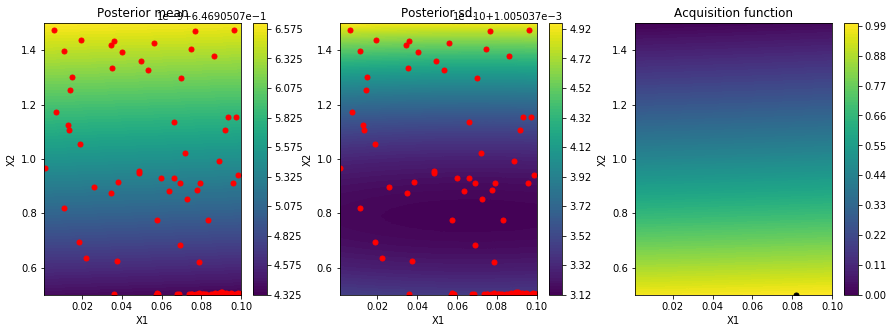

In [18]:
noise_var=None
exact_feval=True
ARD=True
varf=2.5
lf=0.1
xi=0.0001
optimize_restarts=5

initer=50
maxevals=50
nener=10
lpol=3

space=mypolspace(alfd_min,alfd_max,rcut_min,rcut_max)
kernel=mykernel(rbf=1,stdperiodic=0)
pol_best,erelat=run_mybo_pol(space,kernel,initer,maxevals,varf,lf,noise_var,exact_feval,optimize_restarts,ARD,xi)
print("\n terms er%: ")
for i in erelat:
    print("\t     {:.4f}".format(i))

In [20]:
os.system("mv Be* pol* space1/.")

0

In [30]:
alfd_min=0.001
alfd_max=1.50
rcut_min=0.01
rcut_max=1.50

In [32]:
os.system("mkdir space1b")

0

1 3 0.5963 1.3391 0.6450
2 3 1.4611 0.9830 0.9588
3 3 1.3771 0.9153 0.9582
4 3 0.2708 0.8369 0.6460
5 3 1.1616 0.5861 0.9572
6 3 1.0450 1.1979 0.6430
7 3 0.3780 0.5988 0.6454
8 3 0.5196 1.2519 0.6452
9 3 1.4798 0.6682 0.9610
10 3 1.0855 0.5325 0.6412
11 3 0.5083 1.3785 0.6454
12 3 0.7937 1.2402 0.6441
13 3 0.9859 0.6506 0.6421
14 3 0.0790 1.4618 0.6469
15 3 1.0742 0.7871 0.6419
16 3 0.1861 0.9130 0.6464
17 3 0.7199 0.6766 0.6437
18 3 1.3984 0.9856 0.9581
19 3 0.2690 0.2974 0.6459
20 3 0.2816 1.4092 0.6462
21 3 0.7223 0.6879 0.6437
22 3 1.0348 0.2820 0.9634
23 3 0.5117 0.5708 0.6447
24 3 0.0040 0.7055 0.6472
25 3 1.1176 1.3572 0.6430
26 3 0.8344 1.3894 0.6442
27 3 0.5528 0.1946 0.6420
28 3 1.4424 1.4592 0.9562
29 3 0.3226 0.2137 0.6455
30 3 1.1490 1.4580 0.6431
31 3 0.5321 1.4031 0.6453
32 3 1.0332 0.6248 0.6418
33 3 0.7361 1.2908 0.6444
34 3 0.5634 0.6283 0.6445
35 3 0.2120 1.2018 0.6464
36 3 0.8927 0.6504 0.6427
37 3 1.3297 0.7456 0.9586
38 3 0.9473 0.5810 0.6422
39 3 1.1841 0.6202 0.

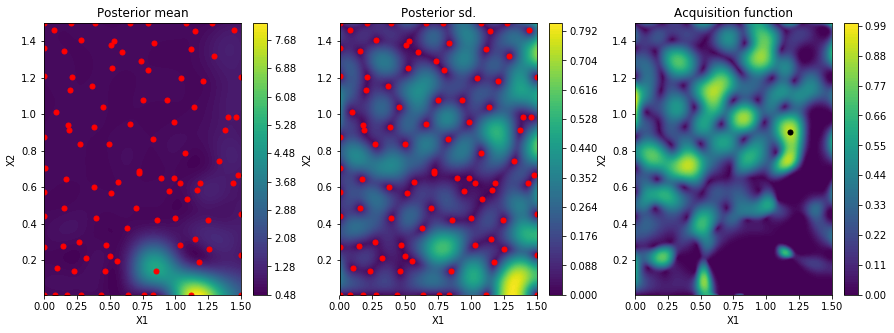

In [31]:
noise_var=None
exact_feval=True
ARD=True
varf=2.5
lf=0.1
xi=0.0001
optimize_restarts=5

initer=50
maxevals=50
nener=10
lpol=3

space=mypolspace(alfd_min,alfd_max,rcut_min,rcut_max)
kernel=mykernel(rbf=1,stdperiodic=0)
pol_best,erelat=run_mybo_pol(space,kernel,initer,maxevals,varf,lf,noise_var,exact_feval,optimize_restarts,ARD,xi)
print("\n terms er%: ")
for i in erelat:
    print("\t     {:.4f}".format(i))

In [33]:
os.system("mv Be* pol* space1b/.")

0

1 3 0.5963 1.3391 0.6450
2 3 1.4611 0.9830 0.9588
3 3 1.3771 0.9153 0.9582
4 3 0.2708 0.8369 0.6460
5 3 1.1616 0.5861 0.9572
6 3 1.0450 1.1979 0.6430
7 3 0.3780 0.5988 0.6454
8 3 0.5196 1.2519 0.6452
9 3 1.4798 0.6682 0.9610
10 3 1.0855 0.5325 0.6412
11 3 0.5083 1.3785 0.6454
12 3 0.7937 1.2402 0.6441
13 3 0.9859 0.6506 0.6421
14 3 0.0790 1.4618 0.6469
15 3 1.0742 0.7871 0.6419
16 3 0.1861 0.9130 0.6464
17 3 0.7199 0.6766 0.6437
18 3 1.3984 0.9856 0.9581
19 3 0.2690 0.2974 0.6459
20 3 0.2816 1.4092 0.6462
21 3 0.7223 0.6879 0.6437
22 3 1.0348 0.2820 0.9634
23 3 0.5117 0.5708 0.6447
24 3 0.0040 0.7055 0.6472
25 3 1.1176 1.3572 0.6430
26 3 0.8344 1.3894 0.6442
27 3 0.5528 0.1946 0.6420
28 3 1.4424 1.4592 0.9562
29 3 0.3226 0.2137 0.6455
30 3 1.1490 1.4580 0.6431
31 3 0.5321 1.4031 0.6453
32 3 1.0332 0.6248 0.6418
33 3 0.7361 1.2908 0.6444
34 3 0.5634 0.6283 0.6445
35 3 0.2120 1.2018 0.6464
36 3 0.8927 0.6504 0.6427
37 3 1.3297 0.7456 0.9586
38 3 0.9473 0.5810 0.6422
39 3 1.1841 0.6202 0.

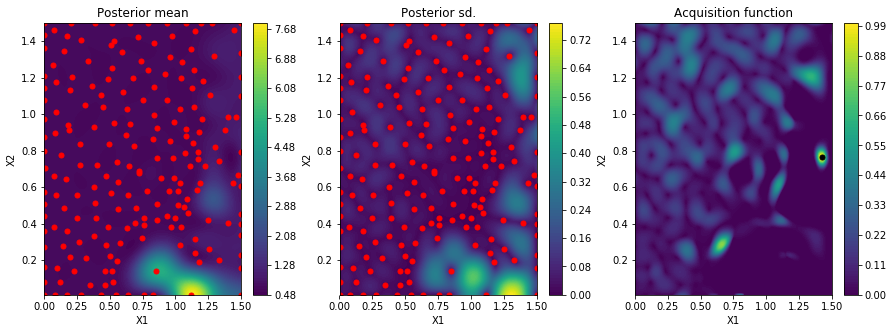

In [34]:
noise_var=None
exact_feval=True
ARD=True
varf=2.5
lf=0.1
xi=0.0001
optimize_restarts=5

initer=50
maxevals=150
nener=10
lpol=3

space=mypolspace(alfd_min,alfd_max,rcut_min,rcut_max)
kernel=mykernel(rbf=1,stdperiodic=0)
pol_best,erelat=run_mybo_pol(space,kernel,initer,maxevals,varf,lf,noise_var,exact_feval,optimize_restarts,ARD,xi)
print("\n terms er%: ")
for i in erelat:
    print("\t     {:.4f}".format(i))

1 3 0.5963 1.3391 0.6450
2 3 1.4611 0.9830 0.9588
3 3 1.3771 0.9153 0.9582
4 3 0.2708 0.8369 0.6460
5 3 1.1616 0.5861 0.9572
6 3 1.0450 1.1979 0.6430
7 3 0.3780 0.5988 0.6454
8 3 0.5196 1.2519 0.6452
9 3 1.4798 0.6682 0.9610
10 3 1.0855 0.5325 0.6412
11 3 0.5083 1.3785 0.6454
12 3 0.7937 1.2402 0.6441
13 3 0.9859 0.6506 0.6421
14 3 0.0790 1.4618 0.6469
15 3 1.0742 0.7871 0.6419
16 3 0.1861 0.9130 0.6464
17 3 0.7199 0.6766 0.6437
18 3 1.3984 0.9856 0.9581
19 3 0.2690 0.2974 0.6459
20 3 0.2816 1.4092 0.6462
21 3 0.7223 0.6879 0.6437
22 3 1.0348 0.2820 0.9634
23 3 0.5117 0.5708 0.6447
24 3 0.0040 0.7055 0.6472
25 3 1.1176 1.3572 0.6430
26 3 0.8344 1.3894 0.6442
27 3 0.5528 0.1946 0.6420
28 3 1.4424 1.4592 0.9562
29 3 0.3226 0.2137 0.6455
30 3 1.1490 1.4580 0.6431
31 3 0.5321 1.4031 0.6453
32 3 1.0332 0.6248 0.6418
33 3 0.7361 1.2908 0.6444
34 3 0.5634 0.6283 0.6445
35 3 0.2120 1.2018 0.6464
36 3 0.8927 0.6504 0.6427
37 3 1.3297 0.7456 0.9586
38 3 0.9473 0.5810 0.6422
39 3 1.1841 0.6202 0.

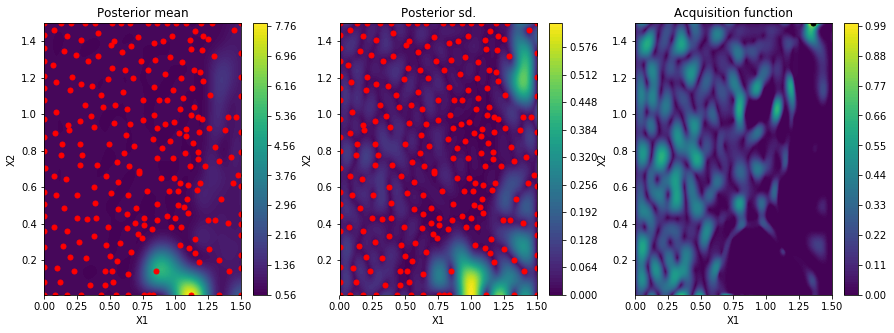

In [41]:
noise_var=None
exact_feval=True
ARD=True
varf=2.5
lf=0.1
xi=0.0001
optimize_restarts=5

initer=50
maxevals=200
nener=10
lpol=3

space=mypolspace(alfd_min,alfd_max,rcut_min,rcut_max)
kernel=mykernel(rbf=1,stdperiodic=0)
pol_best,erelat=run_mybo_pol(space,kernel,initer,maxevals,varf,lf,noise_var,exact_feval,optimize_restarts,ARD,xi)
print("\n terms er%: ")
for i in erelat:
    print("\t     {:.4f}".format(i))

In [42]:
os.system("mv Be* pol* space1b/.")

0

1 3 0.5963 1.2737 0.6449
2 3 1.4611 1.0570 0.9584
3 3 1.3771 0.5694 0.9603
4 3 0.2708 0.8825 0.6460
5 3 1.1616 1.1503 0.6423
6 3 1.0450 0.5431 0.6415
7 3 0.3780 0.5112 0.6454
8 3 0.5196 0.2064 0.6441
9 3 1.4798 0.4150 0.9644
10 3 1.0855 0.9600 0.6423
11 3 0.5083 0.5095 0.6447
12 3 0.7937 0.0214 0.6444
13 3 0.9859 0.7645 0.6424
14 3 0.0790 1.4116 0.6469
15 3 1.0742 0.8854 0.6422
16 3 0.1861 0.6146 0.6463
17 3 0.7199 0.1414 0.6428
18 3 1.3984 1.0936 0.9576
19 3 0.2690 1.1506 0.6461
20 3 0.2816 0.2857 0.6458
21 3 0.7223 1.1333 0.6443
22 3 1.0348 1.3122 0.6432
23 3 0.5117 1.0957 0.6451
24 3 0.0040 1.3804 0.6472
25 3 1.1176 0.6380 0.6413
26 3 0.8344 1.0239 0.6436
27 3 0.5528 0.3988 0.6443
28 3 1.4424 0.4630 0.9625
29 3 0.3226 0.7828 0.6457
30 3 1.1490 1.2244 0.6426
31 3 0.5321 0.1868 0.6474
32 3 1.0332 1.4340 0.6435
33 3 0.7361 0.6882 0.6436
34 3 0.5634 0.5951 0.6444
35 3 0.2120 1.3004 0.6464
36 3 0.8927 1.0350 0.6433
37 3 1.3297 0.3223 0.9742
38 3 0.9473 0.5723 0.6422
39 3 1.1841 0.3957 0.

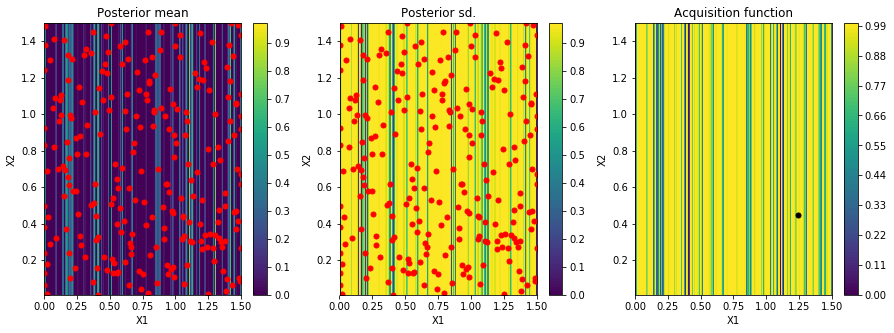

In [44]:
noise_var=None
exact_feval=True
ARD=True
varf=2.5
lf=0.1
xi=0.0001
optimize_restarts=5

initer=100
maxevals=150
nener=10
lpol=3

space=mypolspace(alfd_min,alfd_max,rcut_min,rcut_max)
kernel=mykernel(rbf=1,stdperiodic=0)
pol_best,erelat=run_mybo_pol(space,kernel,initer,maxevals,varf,lf,noise_var,exact_feval,optimize_restarts,ARD,xi)
print("\n terms er%: ")
for i in erelat:
    print("\t     {:.4f}".format(i))

1 3 0.5963 1.2737 0.6449
2 3 1.4611 1.0570 0.9584
3 3 1.3771 0.5694 0.9603
4 3 0.2708 0.8825 0.6460
5 3 1.1616 1.1503 0.6423
6 3 1.0450 0.5431 0.6415
7 3 0.3780 0.5112 0.6454
8 3 0.5196 0.2064 0.6441
9 3 1.4798 0.4150 0.9644
10 3 1.0855 0.9600 0.6423
11 3 0.5083 0.5095 0.6447
12 3 0.7937 0.0214 0.6444
13 3 0.9859 0.7645 0.6424
14 3 0.0790 1.4116 0.6469
15 3 1.0742 0.8854 0.6422
16 3 0.1861 0.6146 0.6463
17 3 0.7199 0.1414 0.6428
18 3 1.3984 1.0936 0.9576
19 3 0.2690 1.1506 0.6461
20 3 0.2816 0.2857 0.6458
21 3 0.7223 1.1333 0.6443
22 3 1.0348 1.3122 0.6432
23 3 0.5117 1.0957 0.6451
24 3 0.0040 1.3804 0.6472
25 3 1.1176 0.6380 0.6413
26 3 0.8344 1.0239 0.6436
27 3 0.5528 0.3988 0.6443
28 3 1.4424 0.4630 0.9625
29 3 0.3226 0.7828 0.6457
30 3 1.1490 1.2244 0.6426
31 3 0.5321 0.1868 0.6474
32 3 1.0332 1.4340 0.6435
33 3 0.7361 0.6882 0.6436
34 3 0.5634 0.5951 0.6444
35 3 0.2120 1.3004 0.6464
36 3 0.8927 1.0350 0.6433
37 3 1.3297 0.3223 0.9742
38 3 0.9473 0.5723 0.6422
39 3 1.1841 0.3957 0.

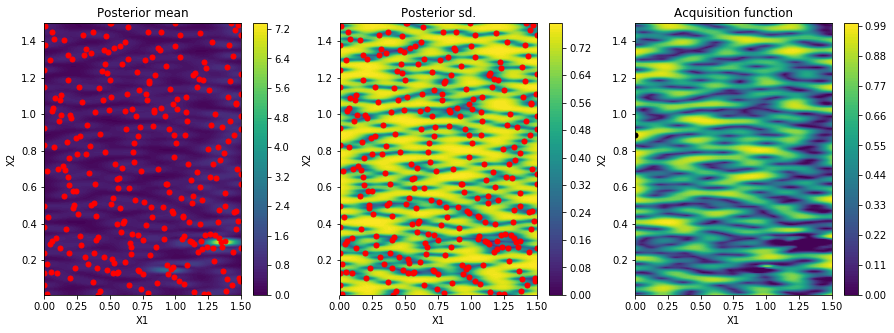

In [45]:
noise_var=None
exact_feval=True
ARD=True
varf=2.5
lf=0.1
xi=0.0001
optimize_restarts=5

initer=100
maxevals=200
nener=10
lpol=3

space=mypolspace(alfd_min,alfd_max,rcut_min,rcut_max)
kernel=mykernel(rbf=1,stdperiodic=0)
pol_best,erelat=run_mybo_pol(space,kernel,initer,maxevals,varf,lf,noise_var,exact_feval,optimize_restarts,ARD,xi)
print("\n terms er%: ")
for i in erelat:
    print("\t     {:.4f}".format(i))

In [46]:
os.system("mv Be* pol* space1b/.")

0

In [ ]:
alfd_min=0.001
alfd_max=1.5 #2.0
rcut_min=0.001
rcut_max=1.50

In [ ]:
noise_var=None
exact_feval=True
ARD=True
varf=2.5
lf=0.1
xi=0.0001
optimize_restarts=5

initer=50
maxevals=150
nener=10
lpol=3

space=mypolspace(alfd_min,alfd_max,rcut_min,rcut_max)
kernel=mykernel(rbf=1,stdperiodic=0)
pol_best,erelat=run_mybo_pol(space,kernel,initer,maxevals,varf,lf,noise_var,exact_feval,optimize_restarts,ARD,xi)
print("\n terms er%: ")
for i in erelat:
    print("\t     {:.4f}".format(i))

In [ ]:
os.system("mv Be* pol* space1_b/.")

In [ ]:
os.system("mkdir space1_c")

In [ ]:
noise_var=None
exact_feval=True
ARD=True
varf=2.5
lf=0.1
xi=0.0001
optimize_restarts=5

initer=100
maxevals=150
nener=10
lpol=3

space=mypolspace(alfd_min,alfd_max,rcut_min,rcut_max)
kernel=mykernel(rbf=1,stdperiodic=0)
pol_best,erelat=run_mybo_pol(space,kernel,initer,maxevals,varf,lf,noise_var,exact_feval,optimize_restarts,ARD,xi)
print("\n terms er%: ")
for i in erelat:
    print("\t     {:.4f}".format(i))

In [ ]:
os.system("mv Be* pol* space1_b/.")

# Iteration check (with other min values)

In [ ]:
os.system("mkdir space1_dbcheck")

In [ ]:
noise_var=None
exact_feval=True
ARD=True
varf=2.5
lf=0.1
xi=0.0001
optimize_restarts=5

initer=50
maxevals=250
nener=10
lpol=3

space=mypolspace(alfd_min,alfd_max,rcut_min,rcut_max)
kernel=mykernel(rbf=1,stdperiodic=0)
pol_best,erelat=run_mybo_pol(space,kernel,initer,maxevals,varf,lf,noise_var,exact_feval,optimize_restarts,ARD,xi)
for i in erelat:
    print(i)

In [ ]:
os.system("mv Be* pol* space1_dbcheck/.")